### Imports and Data Loading

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2

In [2]:
def load_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (32, 32))  # Consistent size
    return img

def load_images(image_paths):
    images = []
    for path in tqdm(image_paths, desc="Loading images"):
        img = load_image(path)
        if img is not None:  # Check if image was loaded successfully
            images.append(img)
        else:
            print(f"Failed to load image: {path}")
    
    print("Images Loaded. Stacking into numpy array...")
    
    # Convert to numpy array with explicit shape
    return np.stack(images)  # Use np.stack with progress tracking

#### Load Images

In [3]:
# Image data loading strings
train_image_label_csv = '/Users/ericcui/repos/imagenette/imagenette2-320/train_imagenette.csv'
val_image_label_csv = "/Users/ericcui/repos/imagenette/imagenette2-320/val_imagenette.csv"
path_prefix = "/Users/ericcui/repos/imagenette/imagenette2-320/"

# Label to index mappings
label_index_mappings = {
    "n01440764": 0,
    "n02102040": 1,
    "n02979186": 2,
    "n03000684": 3,
    "n03028079": 4,
    "n03394916": 5,
    "n03417042": 6,
    "n03425413": 7,
    "n03445777": 8,
    "n03888257": 9,
}

# Label to class mappings
class_mappings = {
    "n01440764": "tench",
    "n02102040": "English springer",
    "n02979186": "cassette player",
    "n03000684": "chain saw",
    "n03028079": "church",
    "n03394916": "French horn",
    "n03417042": "garbage truck",
    "n03425413": "gas pump",
    "n03445777": "golf ball",
    "n03888257": "parachute"
}

In [4]:
# Loading training dataframe
train_df = pd.read_csv(train_image_label_csv)

# Loading training images
image_paths = train_df['path'].tolist()
image_paths = [path_prefix + path for path in image_paths]
train_images = load_images(image_paths)


Loading images: 100%|██████████| 9469/9469 [00:10<00:00, 940.98it/s] 

Images Loaded. Stacking into numpy array...


In [5]:
# Loading validation dataframe
test_df = pd.read_csv(val_image_label_csv)

# Loading validatino images
test_image_paths = test_df['path'].tolist()
test_image_paths = [path_prefix + path for path in test_image_paths]
test_images = load_images(test_image_paths)

Loading images:   0%|          | 0/3925 [00:00<?, ?it/s]

Loading images: 100%|██████████| 3925/3925 [00:04<00:00, 931.33it/s] 

Images Loaded. Stacking into numpy array...


#### Load Training Labels

In [6]:
train_labels = train_df['noisy_labels_0'].tolist()
train_labels = np.array([label_index_mappings[label] for label in train_labels])

In [7]:
test_labels = test_df['noisy_labels_0'].tolist()
test_labels = np.array([label_index_mappings[label] for label in test_labels])

### Rendering CIFAR-10 Images and Labels

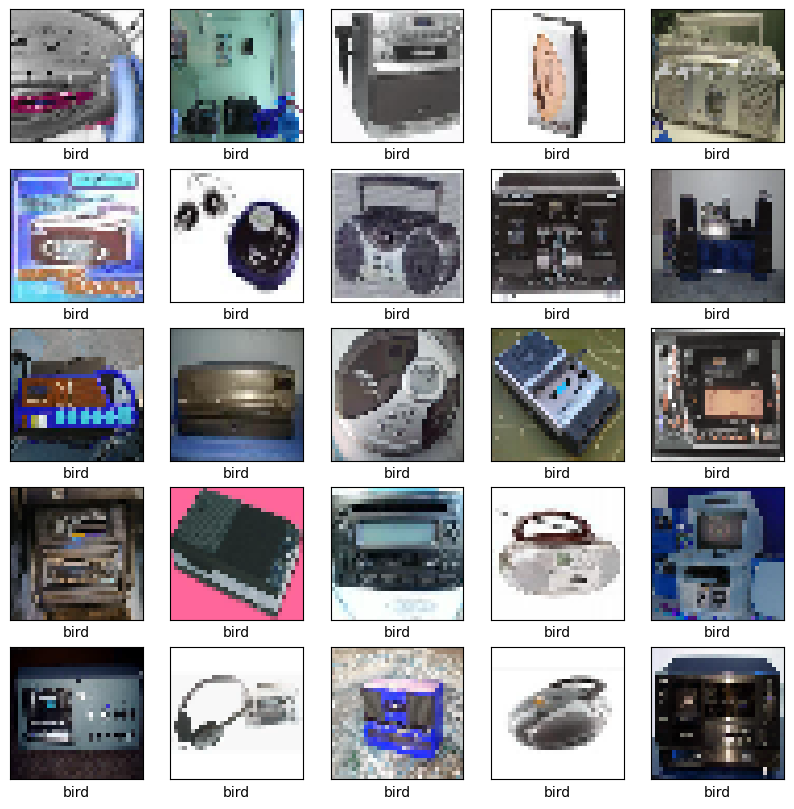

In [15]:
class_names = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### Model Configuration

In [8]:
# CNN Layers
model = models.Sequential()

# Adding a convolutional layer with 32 filters of size 3x3
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Adding a convolutional layer with 64 filters of size 3x3
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Adding a convolutional layer with 64 filters of size 3x3
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Dense Layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

/Users/ericcui/repos/imagenette/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

### Model Compilation and Training

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.1900 - loss: 5.6062 - val_accuracy: 0.2981 - val_loss: 2.0484
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.3873 - loss: 1.7929 - val_accuracy: 0.4010 - val_loss: 1.7597
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.4760 - loss: 1.5651 - val_accuracy: 0.4818 - val_loss: 1.5414
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5359 - loss: 1.3825 - val_accuracy: 0.5014 - val_loss: 1.5177
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5866 - loss: 1.2548 - val_accuracy: 0.5185 - val_loss: 1.4703
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6262 - loss: 1.1323 - val_accuracy: 0.5213 - val_loss: 1.5296
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6633 - loss: 1.0121 - val_accuracy: 0.5238 - val_loss: 1.5573
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7131 - loss: 0.8898 - val_accu

123/123 - 0s - 3ms/step - accuracy: 0.5121 - loss: 1.7785


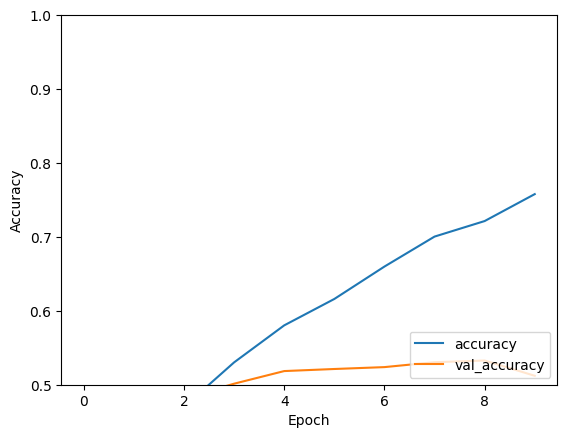

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

### Prototyping